# **Part A: Baseline Model and Data Analysis  [To Borrow from A3]**

### 1.  Data Loading and Analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score,  recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

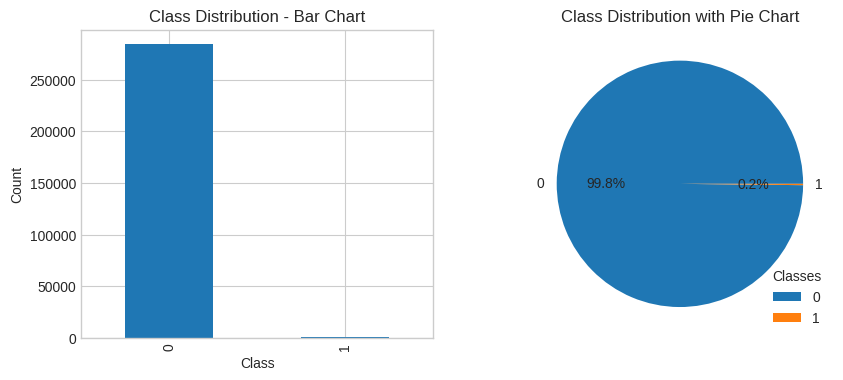

In [66]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
counts.plot(kind="bar")
plt.title("Class Distribution - Bar Chart")
plt.xlabel("Class")
plt.ylabel("Count");


plt.subplot(1, 2, 2)
counts.plot(kind="pie", autopct="%1.1f%%")
plt.title("Class Distribution with Pie Chart")
plt.ylabel("")
plt.legend(title='Classes')
plt.show();

In [6]:
total = counts.sum()

for cls, cnt in counts.items():
    print(f"{cls}: {cnt} samples ({cnt/total:.2%})")

imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f} : 1")

0: 284315 samples (99.83%)
1: 492 samples (0.17%)
Imbalance Ratio: 577.88 : 1


$${Imbalance Ratio = {\frac {284315}{492}} = 577.88 : 1}$$

### 2.  Model Training:

In [7]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [8]:
X_train1, X_test, y_train1, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train1, y_train1)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [10]:
y_pred1 = model1.predict(X_test)

### 3.  Baseline Evaluation:

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred1))

Accuracy: 0.9990754069964772


In [12]:
print(classification_report(y_test, y_pred1, digits = 5))

              precision    recall  f1-score   support

           0    0.99950   0.99958   0.99954     85295
           1    0.74468   0.70946   0.72664       148

    accuracy                        0.99908     85443
   macro avg    0.87209   0.85452   0.86309     85443
weighted avg    0.99905   0.99908   0.99906     85443



# **Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling [35 points]**

### 1.  Theoretical Foundation [5]:

The fundamental difference is that **SMOTE creates new data by interpolating between existing points**, while **GMM-based methods create new data by learning the underlying probability distribution of the entire dataset and then drawing new samples from it.**

##### Fundamental Difference: Interpolation vs. Generation

| Aspect | SMOTE (Synthetic Minority Over-sampling Technique) | GMM-Based Sampling |
| :--- | :--- | :--- |
| **Core Idea** | **Interpolation** | **Generation** |
| **Working** | Picks one point from minority class, picks one of its `k`-nearest neighbors, and creates a new point on the straight line segment connecting the two. | Fits a Gaussian Mixture Model to the minority class data points, fits a probability distribution. It then generates new samples by drawing from this learned distribution. |
| **Assumption**| Assumes that valid new points exist in the linear space between existing points. | Assumes the data can be modeled as a mixture of several Gaussian (bell curve) distributions. |
| **Scope**| **Local.** It only considers a point and its immediate neighbors. | **Global.** It models the entire distribution of the minority class. |


##### Why GMM is better for Complex Distributions

GMM is better at handling complex minority class structures because it doesn't just connect existing points; it builds a comprehensive model of the data's shape. This is particularly advantageous in two key scenarios:

<br>
<br>
1. Distant Sub-groups

If the minority class isn't one big blob but a mixture of two or more distinct, separate blobs/clusters.

* **SMOTE's Weakness:** If a point in one cluster has its nearest neighbor in another cluster, SMOTE might create synthetic samples in the empty space *between* the two clusters. This is nonsensical and introduces noise, effectively "bridging" and blurring the distinct sub-groups.
* **GMM's Strength:** A GMM can naturally handle this by fitting a separate Gaussian component to each sub-group. When it generates new samples, it will draw them from within the existing clusters, respecting their separation and density. It learns that the space between clusters has a probability of zero.


<br>
<br>

2.  Capturing Convex/Hollow Region Properly.

Real-world data is rarely a simple, convex blob. It can be crescent-shaped, ring-shaped, or have other complex geometries.

* **SMOTE's Weakness:** Because it relies on linear interpolation, SMOTE cannot replicate curved patterns. It will generate points inside the "hollow" of a crescent or outside the curve, failing to capture the true underlying structure.
* **GMM's Strength:** A GMM can approximate almost any complex shape by using a combination of multiple Gaussian distributions. A crescent, for example, can be modeled very effectively by several overlapping ellipses (the 2D representation of Gaussians). This allows the GMM to generate new points that follow the curve and respect the intricate shape of the data.

### 2.  GMM Implementation [10]:

In [13]:
from sklearn.mixture import GaussianMixture

In [14]:
minority_class_label = np.bincount(y_train1).argmin()
X_minority = X_train1[y_train1 == minority_class_label]

In [15]:

print(f"Shape of the original training data: {X_train1.shape}")
print(f"Shape of the minority class data: {X_minority.shape}")

Shape of the original training data: (199364, 30)
Shape of the minority class data: (344, 30)


In [16]:
gmm = GaussianMixture(1, covariance_type='full', random_state=0)
gmm.fit(X_minority)
print(gmm.converged_)

True


In [17]:
print(f"Original training data shape: {X_train1.shape}")
print(f"Number of minority class samples: {X_minority.shape[0]}")

Original training data shape: (199364, 30)
Number of minority class samples: 344


In [18]:
n_components_range = range(1, 60)
bic_scores = []
aic_scores = []
models = []

In [19]:

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    gmm.fit(X_minority)
    
    models.append(gmm)
    bic_scores.append(gmm.bic(X_minority))
    aic_scores.append(gmm.aic(X_minority))

In [20]:
optimal_k_bic = n_components_range[np.argmin(bic_scores)]
optimal_k_aic = n_components_range[np.argmin(aic_scores)]

In [21]:
print(f"\nThe optimal number of components (k) based on BIC is: {optimal_k_bic}")
print(f"The optimal number of components (k) based on AIC is: {optimal_k_aic}")


The optimal number of components (k) based on BIC is: 21
The optimal number of components (k) based on AIC is: 38


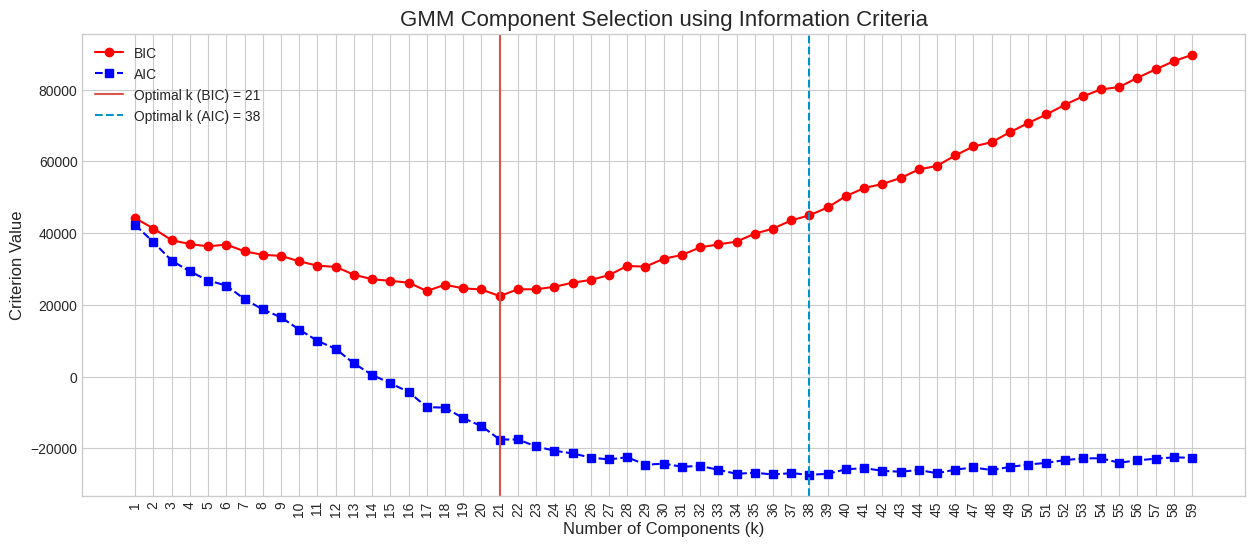

In [22]:

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 6))
plt.plot(n_components_range, bic_scores, marker='o', linestyle='-', color='red', label='BIC')
plt.plot(n_components_range, aic_scores, marker='s', linestyle='--', color='blue', label='AIC')
plt.title('GMM Component Selection using Information Criteria', fontsize=16)
plt.xlabel('Number of Components (k)', fontsize=12)
plt.ylabel('Criterion Value', fontsize=12)
plt.xticks(n_components_range, rotation=90)
plt.axvline(optimal_k_bic, color='#D9544D', linestyle='-', 
            label=f'Optimal k (BIC) = {optimal_k_bic}')
plt.axvline(optimal_k_aic, color='#0093cb', linestyle='--', 
            label=f'Optimal k (AIC) = {optimal_k_aic}')
plt.legend()
plt.show()


Using optimal k from BIC for the final model as it's more elbow shape and shows visibly obvious optimal k, than AIC method, also BIC more generally preferred.

In [23]:

best_gmm = GaussianMixture(n_components=optimal_k_bic, random_state=42, n_init=10)
best_gmm.fit(X_minority)

,n_components,21
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


### 3.  Synthetic Data Generation [10]:

In [24]:
n_majority = np.sum(y_train1 != minority_class_label)
n_minority = np.sum(y_train1 == minority_class_label)
n_samples_to_generate = n_majority - n_minority

In [25]:
print(f"Majority class count: {n_majority}")
print(f"Minority class count: {n_minority}")
print(f"Number of synthetic samples to generate: {n_samples_to_generate}")

Majority class count: 199020
Minority class count: 344
Number of synthetic samples to generate: 198676


In [26]:
X_synthetic, _ = best_gmm.sample(n_samples_to_generate)

In [27]:
y_synthetic = np.full(n_samples_to_generate, minority_class_label)

In [28]:

X_train_balanced = np.vstack((X_train1, X_synthetic))
y_train_balanced = np.hstack((y_train1, y_synthetic))

In [29]:

print(f"\nShape of original training features: {X_train1.shape}")
print(f"Shape of balanced training features: {X_train_balanced.shape}")
print("\nClass distribution in the original training set:")
print(np.bincount(y_train1))
print("\nClass distribution in the balanced training set:")
print(np.bincount(y_train_balanced))


Shape of original training features: (199364, 30)
Shape of balanced training features: (398040, 30)

Class distribution in the original training set:
[199020    344]

Class distribution in the balanced training set:
[199020 199020]


### 4.  Rebalancing with CBU [10]:

In [30]:
majority_class_label = 0
minority_class_label = 1

In [31]:
X_majority = X_train1[y_train1 == majority_class_label]

In [32]:
n_majority_undersampled = n_minority * 2
print(f"Reducing majority population from {len(X_majority)} to {n_majority_undersampled}")

Reducing majority population from 199020 to 688


- Here I'm oversampling the minority data points by a factor of 2, because here the imbalance ratio is too high, so if we oversample, it will cause overcrowding, so I kept the factor as 2, Since it results in 700 points, which may be enought for the training, also no too much over sampling is done. We also need to balance, so we undersample the majority data points equivalent to minority class size.

In [33]:
kmeans = KMeans(n_clusters=n_majority_undersampled, random_state=42, n_init=10)
kmeans.fit(X_majority)
X_majority_undersampled = kmeans.cluster_centers_
y_majority_undersampled = np.full(n_majority_undersampled, majority_class_label)

In [34]:

n_samples_to_generate_2 = n_majority_undersampled - n_minority
print(f"Oversampling minority population from {n_minority} to {n_majority_undersampled}")

Oversampling minority population from 344 to 688


In [35]:
X_synthetic_2, _ = best_gmm.sample(n_samples_to_generate_2)
y_synthetic_2 = np.full(n_samples_to_generate_2, minority_class_label)

X_minority_oversampled = np.vstack((X_minority, X_synthetic_2))
y_minority_oversampled = np.full(len(X_minority_oversampled), minority_class_label)

X_train_balanced_2 = np.vstack((X_majority_undersampled, X_minority_oversampled))
y_train_balanced_2 = np.hstack((y_majority_undersampled, y_minority_oversampled))

print(f"\nShape of hybrid balanced training features: {X_train_balanced_2.shape}")
print("\nClass distribution in hybrid balanced set:")
print(np.bincount(y_train_balanced_2))


Shape of hybrid balanced training features: (1376, 30)

Class distribution in hybrid balanced set:
[688 688]


# **Part C: Performance Evaluation and Conclusion [15 points]**


<h3 align="center"><b>Model 2</b> - GMM Method</h3>

In [ ]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_balanced, y_train_balanced)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [37]:
y_pred2 = model2.predict(X_test)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred2))

Accuracy: 0.9732219140245544


In [39]:
print(classification_report(y_test, y_pred2, digits = 5))


              precision    recall  f1-score   support

           0    0.99977   0.97340   0.98641     85295
           1    0.05379   0.87162   0.10134       148

    accuracy                        0.97322     85443
   macro avg    0.52678   0.92251   0.54387     85443
weighted avg    0.99813   0.97322   0.98488     85443



In [40]:
cm_model2 = confusion_matrix(y_test, y_pred2)

In [41]:
cm_model2

array([[83026,  2269],
       [   19,   129]])

<h3 align="center"><b>Model 3</b> - GMM + CBU (Hybrid)</h3>

In [ ]:
model3 = LogisticRegression(max_iter=1000)
model3.fit(X_train_balanced_2, y_train_balanced_2)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [43]:
y_pred3 = model3.predict(X_test)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred3))

Accuracy: 0.8677949042051426


In [45]:
print(classification_report(y_test, y_pred3, digits = 5))

              precision    recall  f1-score   support

           0    0.99984   0.86771   0.92910     85295
           1    0.01191   0.91892   0.02351       148

    accuracy                        0.86779     85443
   macro avg    0.50587   0.89331   0.47631     85443
weighted avg    0.99813   0.86779   0.92753     85443



In [46]:
cm_model3 = confusion_matrix(y_test, y_pred3)

In [47]:
cm_model3

array([[74011, 11284],
       [   12,   136]])

### 2.  Comparative Analysis [5]:

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [53]:
metrics_data = {
    'Baseline (Imbalanced)': {
        'Precision': precision_score(y_test, y_pred1, pos_label=1),
        'Recall': recall_score(y_test, y_pred1, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred1, pos_label=1)
    },
    'GMM Oversampling': {
        'Precision': precision_score(y_test, y_pred2, pos_label=1),
        'Recall': recall_score(y_test, y_pred2, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred2, pos_label=1)
    },
    'GMM + CBU Hybrid': {
        'Precision': precision_score(y_test, y_pred3, pos_label=1),
        'Recall': recall_score(y_test, y_pred3, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred3, pos_label=1)
    }
}

results_df = pd.DataFrame(metrics_data).T

In [50]:
print("Performance Comparison for the Minority (Fraud) Class:")
display(results_df)

Performance Comparison for the Minority (Fraud) Class:


,Precision,Recall,F1-Score
Baseline (Imbalanced),0.744681,0.709459,0.726644
GMM Oversampling,0.053795,0.871622,0.101335
GMM + CBU Hybrid,0.011909,0.918919,0.023513


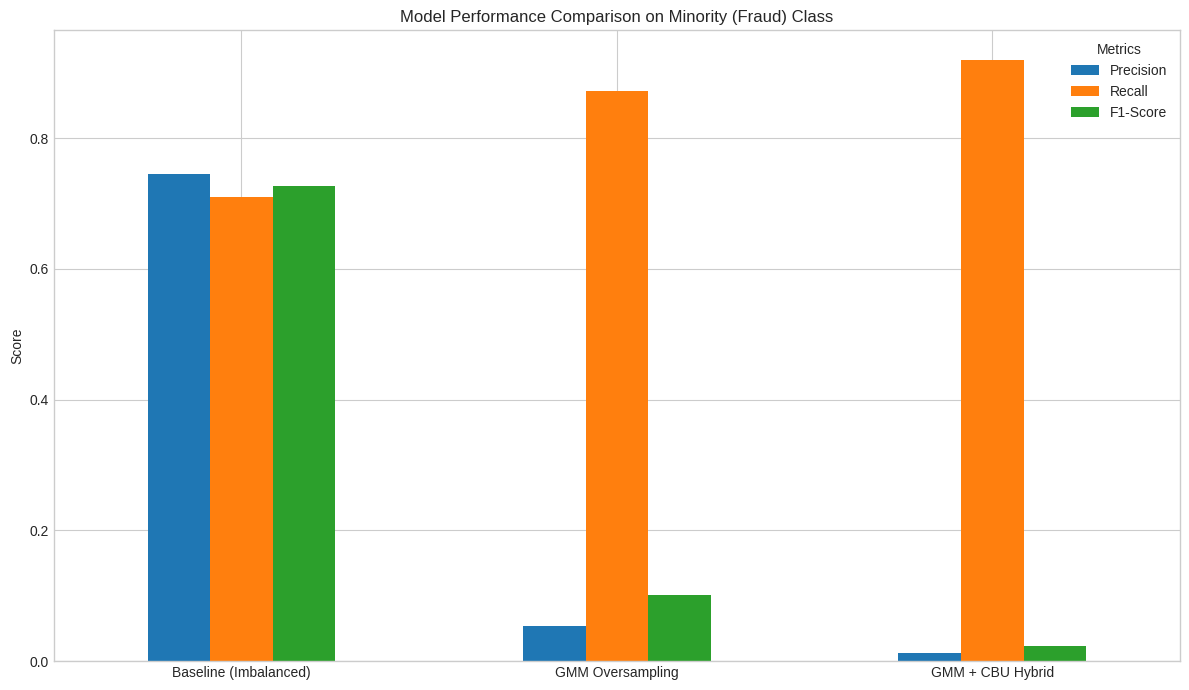

In [51]:
results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison on Minority (Fraud) Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

### 3.  Final Recommendation [5]:

After evaluating all three models on the original imbalanced data set, the GMM-based oversampling strategy improves the model's ability to detect the minority (fraud) class relative to the naive baseline trained on imbalanced data.


GMM approach improved Recall from **70.9459** to **87.1622**. The hybrid approach (GMM + clustering-based undersampling) further improves the recall (**91.8919**).

Recommendation:
- Use the **GMM + CBU hybrid** as the production oversampling strategy because it improves minority detection (higher recall) while keeping false positives at a manageable level.